In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import math as m

## System description
Invision a system where a single aircraft (aircraft #2) is flying in a GPS-denied / degraded scenario, but it has a communication link back with a different aircraft (aircraft #1).  This other aircraft is flying in a GPS-enabled scenario.  This link also measures the range from aircraft 1 to aircraft 2.  In addition, aircraft 2 is able to observe three points on the ground using a bearing-only sensor (i.e. a camera).  We would like to estimate the location of aircraft #2 over time.  Because aircraft #1 has GPS, we assume that its position estimates are always known and perfectly accurate.  

The goal of this project is to estimate the location of the aircraft #2 over time.  Its measurements are its local dynamics model, 3 bearing measurements to landmarks of unknown location, and the range sensor to a moving, known position.  A graph-based view of the states being estimated are below, though "aircraft1" is known and not estimated.

![LSO Graph](LSO_assign.png)

## Dynamics model
This code simulates two moving aircraft at different altitudes.  The model for each aircraft is assuming it stays at a fixed altitude.  We will be ignoring pitch and roll and modeling only yaw.  Therefore, the state vector for each aircraft will be:
$$\vec{x} = \begin{pmatrix}x\\y\\z\\ \psi\end{pmatrix}$$
and the dynamic model will be 
$$\dot{\vec{x}} = \begin{pmatrix}V \cos \psi \\ V \sin\psi \\-\kappa(z - h_t) \\ u\end{pmatrix} + w$$
where $V$ is the velocity of the aircraft, $u$ is the turn rate command (correlated with roll in fixed wing flight), $\kappa$ is the gain parameter on a proportional controller, and $h_t$ is the target altitude.  The noise parameter $w$ is additive white Gaussian noise, with mean 0 and covariance $Q$.  Note that altitude will end up being a first-order Gauss-Markov random process, with its covariance defined by $Q$ and $\kappa$.

### Notes
All positions will be in the North-East-Down (NED) coordinate frame.

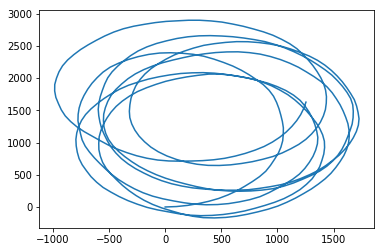

In [18]:
def boundAngle(input_angle: float):
    new_angle = input_angle
    if new_angle > m.pi:
        new_angle -= 2.0*m.pi
    if new_angle < -m.pi:
        new_angle += 2.0*m.pi
    return new_angle
    
def aircraftPositionSim(V: float, u: float, ht: float, Q: np.array, N: int, 
                        dt: float, init_x : np.array, ss_rate:int = 10, kappa = .1) -> np.array:
    # V, u, ht, and Q as defined in markdown above
    # N is how many timesteps you want
    # dt is how far apart each time step should be
    # init_x is the initial location of the aircraft
    # ss_rate is how many internal iterations it should do for each timestep
    going_out = np.zeros((4,N+1))
    going_out[:,0] = init_x
    curr_x = init_x.reshape(4,1)
    dt_i = dt/float(ss_rate) #internal_dt
    Q_i = Q / float(ss_rate) # internal_Q
    cholQ_i = la.cholesky(Q_i)
    for ii in range(1,N+1):
        next_x = curr_x.copy()
        for jj in range(ss_rate):
            next_x[0] += dt_i * V * m.cos(next_x[3])
            next_x[1] += dt_i * V * m.sin(next_x[3])
            next_x[2] += dt_i * kappa * (ht - next_x[2])
            next_x[3] += dt_i * u
            next_x += np.dot(cholQ_i,rand.normal(size=(4,1)))
            next_x[3] = boundAngle(next_x[3])
        curr_x = next_x
        going_out[:,ii] = next_x.reshape((4))
    return going_out

#Test if this works... u=5 degrees means 72 seconds to make a circle
to_plot = aircraftPositionSim(100,np.radians(5),10000, np.diag([.09, .09, 1, np.radians(.1)]),
                             500,1,np.array([0.,0.,10000.,0.]))
plt.plot(to_plot[0,:],to_plot[1,:])

## Measurement model

### Bearing measurements
So we now have code to simulate two aircraft flying around.  Now let's define the factors (edges in the graph).  Assume that both the landmark ($Li$) and aircraft ($xj$) location can be written as a three-dimesional object ($(Li_x,Li_y,Li_z)$ and $(xj_x, xj_y, xj_z)$ respectively).  The bearing measurement $b$ will consist of two angle measurements ($b1$ and $b2$) expressed as:
$$\begin{align}b1 &= atan2(Li_y-xj_y, Li_x-xj_x)\\
hd &= \sqrt{(Li_x-xj_x)^2 + (Li_y-xj_y)^2}\\
b2 &= atan2(xj_z-Li_z, hd)\\
b &= [b1\  b2]^\top \boxplus v
\end{align}$$
where $v$ is additive white Gaussian noise terms with mean 0 and covariance $R_b$.

### Range measurements
The range measurement at each step assumes the position of Aircraft 1 at time $j$ $(a1j_x, a1j_y, a1j_z)$ is known.  The measurement ($r$) is
$$ r = \sqrt{(a1j_x - xj_x)^2 + (a1j_y - xj_y)^2 + (a1j_z - xj_z)^2}$$

In [30]:
def bearingMeasure(ac_loc, l_loc) :
    b1 = m.atan2(l_loc[1] - ac_loc[1],l_loc[0] - ac_loc[0]) - ac_loc[3]
    hd = m.sqrt((l_loc[1] - ac_loc[1])**2. + (l_loc[0] - ac_loc[0])**2.)
    b2 = m.atan2(ac_loc[2] - l_loc[2], hd)
    return (b1,b2)

def vecFromBearing(bearing):
    bvxy = np.array([m.cos(bearing[0]), m.sin(bearing[0])]) #bearing_vec_xy
    going_out = np.array([m.cos(bearing[1])*bvxy[0], m.cos(bearing[1])*bvxy[1], -m.sin(bearing[1])])
    return going_out

def bearingManifoldAdd(bearing, to_add):
    #This assumes 2-D inputs
    #The bearing "manifold" will be made such that "b2_axis" is pointing in the direction of the heading as much as possible
    
    #First, form the bearing vector from the angles
    bearing_vec = vecFromBearing(bearing)
    #Now form the incremental axes for this bearing measurements
    b1_vec = np.cross(bearing_vec, np.array([0,0,-1]))
    if la.norm(b1_vec) < 1E-8:
        b2_vec = np.array([0,0,-1])
        b1_vec = np.cross(bearing_vec,b2_vec)
    else:
        b1_vec = b1_vec/la.norm(b1_vec)
        b2_vec = np.cross(b1_vec, bearing_vec)
        b2_vec = b2_vec/la.norm(b2_vec)
    #The coordinate axes are now defined.  Go ahead and add
    out_vec = bearing_vec + to_add[0]*b1_vec + to_add[1]*b2_vec
    xy_mag = m.sqrt(out_vec[0]**2.0 + out_vec[1]**2.0)
    tmp1 = m.atan2(out_vec[1],out_vec[0])
    tmp2 = m.atan2(out_vec[2],xy_mag)
    return np.array((tmp1,tmp2))
    
#simple tests
ac_loc = np.array([0.,0.,0.,0.])
l_loc = np.array([0.,0.,1.])
print ('Bearing measurements when straight below aircraft ... should be 0, -pi/2',bearingMeasure(ac_loc,l_loc))
ac_loc = np.array([0.,0.,0.,np.radians(45)])
print ('Bearing measurements when straight below aircraft but aircraft 45 degrees to right',bearingMeasure(ac_loc,l_loc))
l_loc = np.array([1.,0.,1.])
print ('Bearing measurements when straight ahead and below aircraft ... should be 0, -pi/4',bearingMeasure(ac_loc,l_loc))
l_loc = np.array([1.,1.,0.])
print ('Bearing measurements when ahead and to the right aircraft ... should be pi/4, 0',bearingMeasure(ac_loc,l_loc))
l_loc = np.array([1.,1.,-m.sqrt(2.0)])
print ('Bearing measurements when ahead, right, and up of aircraft ... should be pi/4, -pi/4',bearingMeasure(ac_loc,l_loc))


Bearing measurements when straight below aircraft ... should be 0, -pi/2 (0.0, -1.5707963267948966)
Bearing measurements when straight below aircraft but aircraft 45 degrees to right (-0.7853981633974483, -1.5707963267948966)
Bearing measurements when straight ahead and below aircraft ... should be 0, -pi/4 (-0.7853981633974483, -0.7853981633974483)
Bearing measurements when ahead and to the right aircraft ... should be pi/4, 0 (0.0, 0.0)
Bearing measurements when ahead, right, and up of aircraft ... should be pi/4, -pi/4 (0.0, 0.7853981633974483)


In [31]:
def rangeMeasure(ac1_loc, ac2_loc):
    return la.norm(ac2_loc-ac1_loc)

#simple tests
ac1_loc = np.array([0.,0.,0.])
ac2_loc = np.array([0.,0.,2.])
print ('2 meters apart, measurement is...',rangeMeasure(ac1_loc, ac2_loc))
ac2_loc = np.array([m.sqrt(1./3.), m.sqrt(1./3.), m.sqrt(1./3.)])
print ('1 meters apart, measurement is...',rangeMeasure(ac1_loc, ac2_loc))

2 meters apart, measurement is... 2.0
1 meters apart, measurement is... 1.0


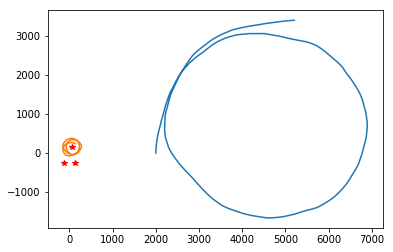

In [42]:
#Now let's create a system and its measurements.  Let's start with the parameters that define the system.
#system parameters
N = 400
dt = .5
R_b = np.diag([np.radians(.5), np.radians(.5)]) #bearing measurements with 1/2 degree errors std. dev.
R_r = np.array([.5]) #10cm ranging error
R_b_chol = la.cholesky(R_b)

#aircraft1 parameters
ac1_start = np.array([0., 2000., -1000.,0.])
ac1_V = 100
ac1_u = np.radians(2)
ac1_ht = -1000
ac1_Q = np.diag([.09, .09, 1, np.radians(.1)])

#aircraft2 parameters
ac2_start = np.array([0., 0., -100.,rand.uniform(0,2*m.pi)])
ac2_V = 15
ac2_u = np.radians(5)
ac2_ht = -100
ac2_Q = np.diag([.25, .25, 1, np.radians(.1)])

#true landmark locations
xyr = (-300,300) #x y range
zr = (-10,10) # z range
l1 = np.array([rand.uniform(xyr[0],xyr[1]), rand.uniform(xyr[0],xyr[1]), rand.uniform(zr[0],zr[1])])
l2 = np.array([rand.uniform(xyr[0],xyr[1]), rand.uniform(xyr[0],xyr[1]), rand.uniform(zr[0],zr[1])])
l3 = np.array([rand.uniform(xyr[0],xyr[1]), rand.uniform(xyr[0],xyr[1]), rand.uniform(zr[0],zr[1])])

#Now make the flight patterns and measurements!
ac1_path = aircraftPositionSim(ac1_V, ac1_u, ac1_ht, ac1_Q, N, dt, ac1_start)
ac2_path = aircraftPositionSim(ac2_V, ac2_u, ac2_ht, ac2_Q, N, dt, ac2_start)
bearing_meas_l1 = np.zeros((2,N))
bearing_meas_l2 = np.zeros((2,N))
bearing_meas_l3 = np.zeros((2,N))
range_meas = np.zeros((N,1))
for i in range(N):
    bearing_meas_l1[:,i] = bearingManifoldAdd(np.array(bearingMeasure(ac2_path[:,i],l1)).reshape(2,1),
                                              np.dot(R_b_chol,rand.normal(size=(2,1)))).reshape(2)
    bearing_meas_l2[:,i] = bearingManifoldAdd(np.array(bearingMeasure(ac2_path[:,i],l2)).reshape(2,1),
                                              np.dot(R_b_chol,rand.normal(size=(2,1)))).reshape(2)
    bearing_meas_l3[:,i] = bearingManifoldAdd(np.array(bearingMeasure(ac2_path[:,i],l3)).reshape(2,1),
                                              np.dot(R_b_chol,rand.normal(size=(2,1)))).reshape(2)
    range_meas[i] = rangeMeasure(ac1_path[:,i],ac2_path[:,i]) + m.sqrt(R_r) * rand.normal()

plt.plot(ac1_path[1,:],ac1_path[0,:])
plt.plot(ac2_path[1,:],ac2_path[0,:])
plt.plot(l1[1],l1[0],'*r')
plt.plot(l2[1],l2[0],'*r')
plt.plot(l3[1],l3[0],'*r')

# Assignment
## Primary assignment
Using the code above, you can generate a set of measurements.  Take these measurements and use a (weighted) Least Squared Optimization procedure to determine the estimated aircraft2 location over time and landmark locations.  Evaluate the accuracy of your technique both in terms of aircraft2 location but also how accurately the landmarks are estimated.

### Warning:
There are two places where the space is actually non-Euclidean.  First, the heading direction of the aircraft.  The distance from $-\pi + \epsilon$ to $\pi - \epsilon$ is only $2\epsilon$ (very small).  However, if you treat it as a Euclidean space, you get $2\pi -2\epsilon$, which is relatively big.

Similarly, the bearing measurements are usually okay, but when the landmark is close to being directly underneath the aircraft, the actual distance between measurements $(k,-\pi/2)$ is actually very small for any two values of $k$, but if you assume it is Euclidean, it will be big.

## Analysis
Modify the R values to give different amount of noise to each measurements.  Which measurement has a larger effect on the overall error?